Example analysis showcasing some of the possibilities of MESA-LVQ, applied to a toy example dataset from `scikit-survival`. 
Specifically, we use the AIDS clinical trial dataset since it has 2 competing events: AIDS (for 96 patients) and death (for 26 patients).

1. Loading and preprocessing the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.datasets import load_aids
from mesaLVQ.data import multi_surv_from_arrays, split_train_test, SkewTransformer

X, y1 = load_aids("aids" )
_, y2 = load_aids("death")
X = pd.DataFrame(SkewTransformer().fit_transform(X), index=X.index, columns=X.columns)
cens = np.stack((y1["censor"], y2["censor_d"])).T
time = np.stack((y1["time"], y2["time_d"])).T
y = multi_surv_from_arrays(cens, time)
X_train, X_test, y_train, y_test = split_train_test(X, y)

2. Exploratory data analysis.

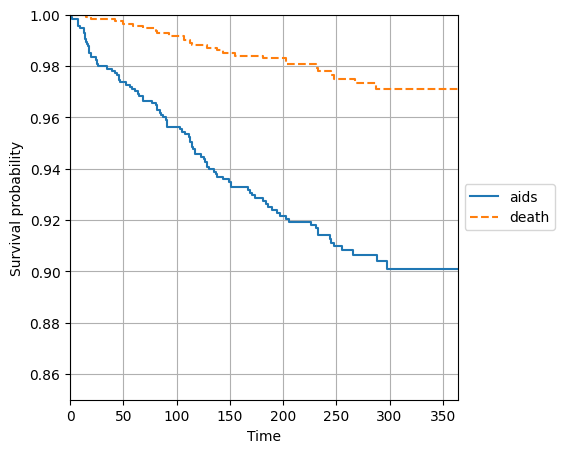

In [2]:
from mesaLVQ.plot import plot_multievent_kaplan_meier
event_names = ["aids", "death"]
plot_multievent_kaplan_meier(y, event_names=event_names, ylim=[0.85, 1])

3. Fitting the model.

In [3]:
from mesaLVQ.model import MultiEventSurvivalLVQ
mesalvq = MultiEventSurvivalLVQ(n_prototypes=3, verbose=False)
mesalvq.fit(X_train, y_train)

MultiEventSurvivalLVQ()

4. Scoring the model based on internal clustering validity criteria (on the training set). You can use this function to compare to the results of other models as well.

In [4]:
from mesaLVQ.score import compute_cluster_validity
y_pred_train = mesalvq.predict(X_train, closest=True)
scores = compute_cluster_validity(X_train, y_pred_train)
pd.Series(scores)

negated_ball_hall_index        -27.395236
calinski_harabasz_index         99.312997
negated_davies_bouldin_index    -2.343857
silhouette_index                 0.138167
generalised_dunn_index           0.107836
dtype: float64

5. Score the model based on predictive performance metrics (on the testing set). 
   
   Note that `times` (used for IBS/IAUROC calculation) can be set manually (e.g. `np.linspace(100,300,100)`). If left to `None`, it is automatically chosen based on the provided `y_test` (specifically, linspace between 10% and 90% quantiles).

In [5]:
from mesaLVQ.score import compute_predictive_performance
y_pred_test = mesalvq.predict(X_test)
y_pred_survfunc_test = mesalvq.predict_survival_function(X_test)
scores = compute_predictive_performance(y_train, y_test, y_pred_test, y_pred_survfunc_test, times=None)
pd.DataFrame(scores, index=event_names)

,harrell_c,unos_c,integr_brier,integr_auroc
aids,0.788988,0.787143,0.068789,0.815789
death,0.846295,0.871657,0.021579,0.833553


6. Make some figures of the model. It seems that prototype 2 has the worst prognosis on both events. From the loadings, we see that this prototype has lowest `cd4`, `karnoff`, `tx` and `txgrp` compared to the average patient.

   For more graphs of interest, see `mesaLVQ.plot` or `main.py:plot_models` (e.g. logrank comparisons of the clusters, plotting the AUROC over time...)

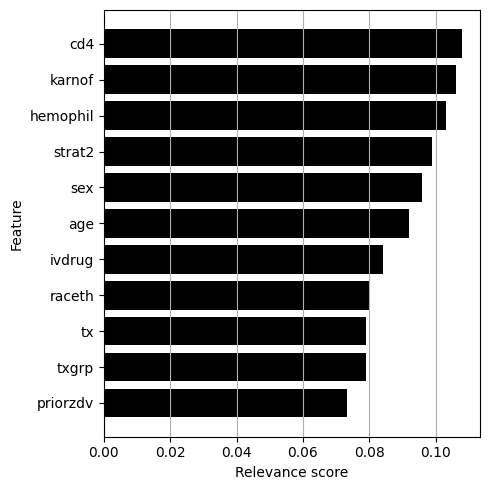

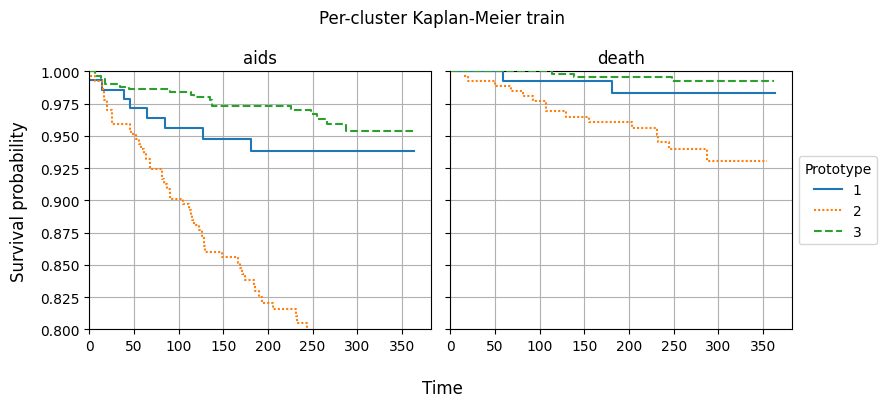

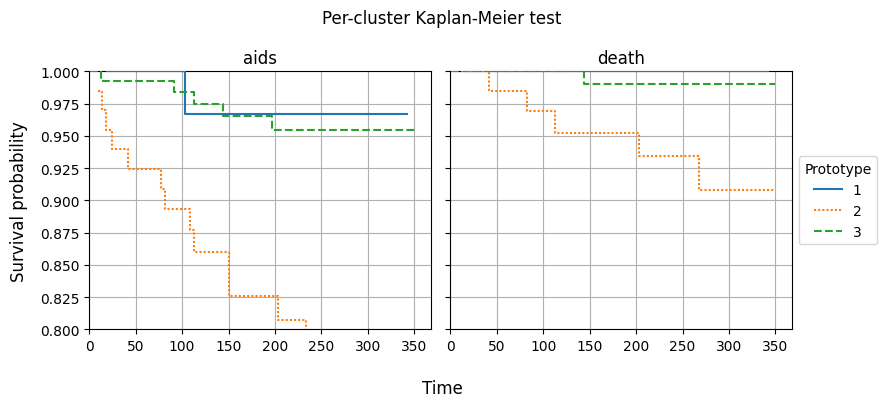

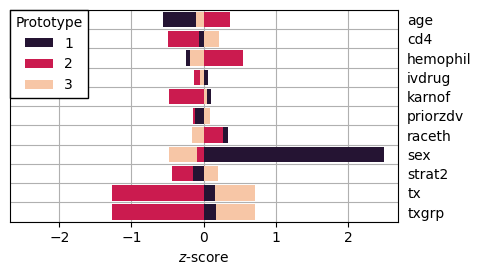

In [6]:
from mesaLVQ.plot import plot_feature_relevances, plot_kaplan_meier_per_cluster, plot_prototypes
names = X.columns

# Feature relevances: diagonal of the relevance matrix
plot_feature_relevances(mesalvq, names=names)

# Kaplan-Meier disambiguation per event
y_pred_train = mesalvq.predict(X_train, closest=True)
y_pred_test  = mesalvq.predict(X_test , closest=True)
kwargs = {"subplots_params": dict(nrows=1, ncols=2, figsize=(9,4)),
          "event_names": event_names}
def adjust_figure(on_train=True):
    fig, ax = plt.gcf(), plt.gca()
    ax.legend(loc="center left", bbox_to_anchor=[1, 0.5], title="Prototype")
    ax.set_ylim([0.8, 1]) # adjust for rare event
    fig.supxlabel("Time")
    fig.supylabel("Survival probability")
    fig.suptitle("Per-cluster Kaplan-Meier " + ["train","test"][~on_train])
    fig.tight_layout()
plot_kaplan_meier_per_cluster(X_train, y_train, y_pred_train, **kwargs)
adjust_figure(on_train=True)
plot_kaplan_meier_per_cluster(X_test, y_test, y_pred_test, **kwargs)
adjust_figure(on_train=False)

# Prototype loadings
loadings = mesalvq.w.detach().numpy()
plot_prototypes(loadings, names)

7. Optional: comparison to the local approach (multiple SurvivalLVQ objects per cluster).

    Note that the results are a bit different from the paper, now the global approach is predictively much better than the local approach, but worse or equal in terms of clustering metrics. However, this varies from run to run, and could be related to not tuning the hyperparameters of the method for this example use case.

,negated_ball_hall_index,calinski_harabasz_index,negated_davies_bouldin_index,silhouette_index,generalised_dunn_index
global,-27.395236,99.312997,-2.343857,0.138167,0.107836
local (mean),-26.375376,125.246751,-2.215358,0.136308,0.1475
local_0,-27.071339,113.325172,-2.373121,0.122353,0.140573
local_1,-25.679413,137.16833,-2.057595,0.150262,0.154426
global_is_better,False,False,False,True,False


aids     death
metric       model                          
harrell_c    MESA-LVQ     0.788988  0.846295
             SurvivalLVQ  0.731218  0.817932
integr_auroc MESA-LVQ     0.815789  0.833553
             SurvivalLVQ  0.744015  0.817151
integr_brier MESA-LVQ     0.068789  0.021579
             SurvivalLVQ  0.070033  0.021612
unos_c       MESA-LVQ     0.787143  0.871657
             SurvivalLVQ  0.725484  0.826653

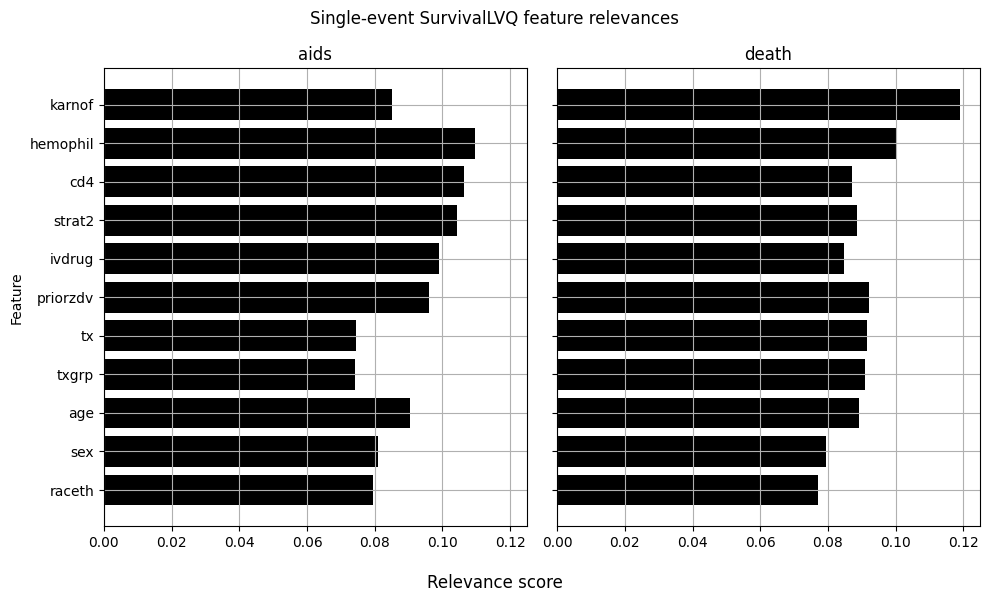

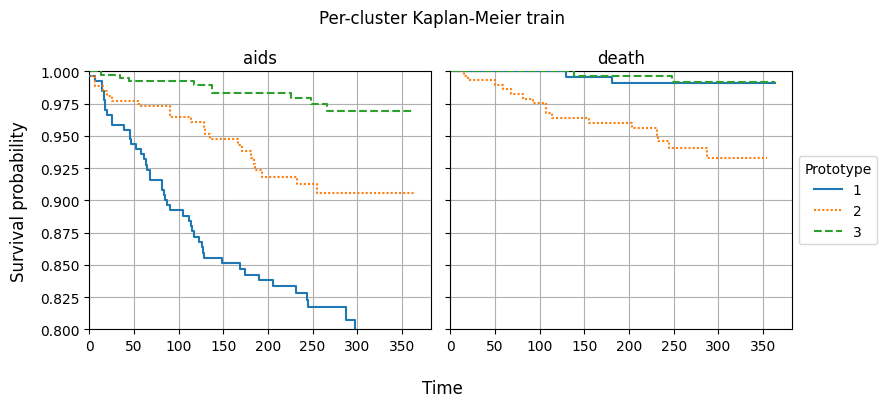

In [7]:
from mesaLVQ.model import SurvivalLVQ, LocalMultiEventSurvivalLVQ
from mesaLVQ.score import compare_cluster_validity, compare_predictive_performance
from mesaLVQ.plot import plot_feature_relevances_local
from IPython.display import display

# 3. Fit the local approach
sesalvq = [SurvivalLVQ(n_prototypes=3, verbose=False) for _ in range(y_train.shape[1])]
sesalvq = LocalMultiEventSurvivalLVQ(sesalvq)
sesalvq.fit(X_train, y_train)

# 4. Internal validity criteria comparison
y_pred_global = mesalvq.predict(X_train, closest=True)
y_pred_local  = sesalvq.predict(X_train, closest=True)
scores = compare_cluster_validity(X_train, y_pred_global, y_pred_local)
display(scores)

# 5. Predictive performance metrics comparison
scores = compare_predictive_performance(mesalvq, sesalvq, X_train, y_train, X_test, y_test, event_names=event_names)
display(scores)

# 6. Some figures for the local model
# > Feature relevances
plot_feature_relevances_local(sesalvq, names=names, event_names=event_names)
plt.suptitle("Single-event SurvivalLVQ feature relevances")
plt.tight_layout()
# > Kaplan-Meier per cluster
y_pred_train = sesalvq.predict(X_train, closest=True)
y_pred_test  = sesalvq.predict(X_test , closest=True)
plot_kaplan_meier_per_cluster(X_train, y_train, y_pred_train, **kwargs)
adjust_figure(on_train=True)